In [20]:
import torch # to create tensors to store the raw data, weights and biases 
import torch.nn as nn # to make the weights and biases learnable (part of the network)
import torch.nn.functional as F # to apply activation functions 
from torch.optim import Adam  
from torch.distributions.uniform import Uniform

import lightning as L # to train the model 
from torch.utils.data import DataLoader, TensorDataset # to load the data 
from lightning.pytorch.tuner.tuning import Tuner      
from lightning.pytorch.callbacks import ModelCheckpoint #Lightning is trying to delete the previous checkpoint (because the default ModelCheckpoint is set to save_top_k=1).
                                                        # On Windows a file gets locked as soon as any program (Explorer preview, antivirus, TensorBoard, VS Code, …) opens it, and Windows then blocks the delete call ⇒ PermissionError WinError 32

import pandas as pd # to load the data 

import matplotlib.pyplot as plt # graphs 
import seaborn as sns # graphs


In [21]:
inputs= torch.tensor([[1.,0.,0.,0.],
                    [0.,1.,0.,0.],
                    [0.,0.,1.,0.],
                    [0.,0.,0.,1.]])
labels= torch.tensor([[0.,1.,0.,0.], 
                    [0.,0.,1.,0.],
                    [0.,0.,0.,1.],
                    [0.,1.,0.,0.]])

dataset= TensorDataset(inputs,labels)
dataloader= DataLoader(dataset)

In [25]:
class WordEmbeddingFromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()

        min_value=-0.5
        max_value=0.5

        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.loss= nn.CrossEntropyLoss()

    def forward(self, input):
        input= input[0] # to remove the set of [] from the input list we get from the list 

        input_to_top_hidden = ((input[0] * self.input1_w1) +(input[1] * self.input2_w1) +(input[2] * self.input3_w1) +(input[3] * self.input4_w1))

        input_to_bottom_hidden = ((input[0] * self.input1_w2) +(input[1] * self.input2_w2) +(input[2] * self.input3_w2) +(input[3] * self.input4_w2))

        output1= (input_to_top_hidden * self.output1_w1) +(input_to_bottom_hidden * self.output1_w2)

        output2= (input_to_top_hidden * self.output2_w1) +(input_to_bottom_hidden * self.output2_w2)

        output3= (input_to_top_hidden * self.output3_w1) +(input_to_bottom_hidden * self.output3_w2)

        output4= (input_to_top_hidden * self.output4_w1) +(input_to_bottom_hidden * self.output4_w2)

        output_presoftmax = torch.stack([output1, output2, output3, output4]) # we use torch.stack to preserve the gradients of the output

        return output_presoftmax

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.1)

    def training_step(self, batch, batch_idx):
        input_i,label_i = batch
        output_i=self.forward(input_i)
        loss=self.loss(output_i, label_i[0])
        return loss



In [26]:
modelFromScratch=WordEmbeddingFromScratch()

print("before optimization, the parameters are:")
for name,param in modelFromScratch.named_parameters():
    print(name, param.data)

before optimization, the parameters are:
input1_w1 tensor(-0.1620)
input1_w2 tensor(0.2243)
input2_w1 tensor(0.2362)
input2_w2 tensor(-0.4222)
input3_w1 tensor(-0.2228)
input3_w2 tensor(-0.2710)
input4_w1 tensor(-0.3389)
input4_w2 tensor(-0.4558)
output1_w1 tensor(0.0278)
output1_w2 tensor(-0.2346)
output2_w1 tensor(-0.2812)
output2_w2 tensor(0.3930)
output3_w1 tensor(-0.3628)
output3_w2 tensor(-0.2595)
output4_w1 tensor(-0.0391)
output4_w2 tensor(-0.2071)


In [27]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df

,w1,w2,token,input
0,-0.161962,0.224262,Troll2,input1
1,0.236194,-0.422188,is,input2
2,-0.222846,-0.271002,great,input3
3,-0.338895,-0.455759,Gymkata,input4


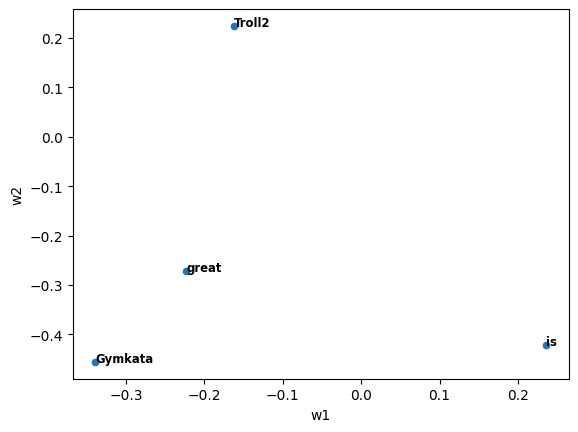

In [28]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()

In [29]:
ckpt_cb = ModelCheckpoint(save_top_k=-1)   # -1 = keep everything

trainer=L.Trainer(max_epochs=100,callbacks=[ckpt_cb])
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\lightning\pytorch\loops\fit_loop.p

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 203.02it/s, v_num=70]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 156.09it/s, v_num=70]


In [31]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}

df = pd.DataFrame(data)
df


,w1,w2,token,input
0,-1.847581,1.628782,Troll2,input1
1,2.195506,-2.248843,is,input2
2,-1.805863,-3.071294,great,input3
3,-2.017890,1.184395,Gymkata,input4


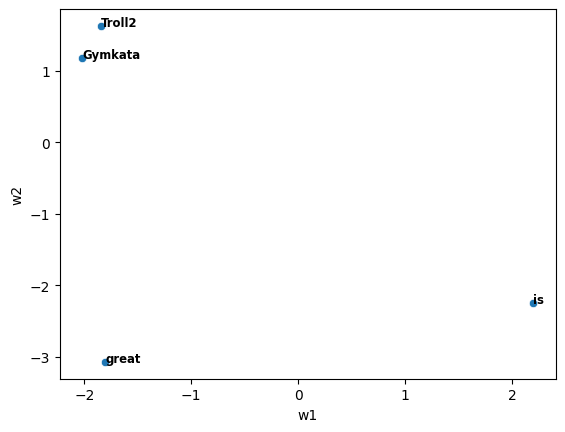

In [32]:
sns.scatterplot(data=df, x="w1", y="w2")
plt.text(df.w1[0], df.w2[0], df.token[0], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[1], df.w2[1], df.token[1], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[2], df.w2[2], df.token[2], horizontalalignment="left",color="black",size='small',weight='semibold')
plt.text(df.w1[3], df.w2[3], df.token[3], horizontalalignment="left",color="black",size='small',weight='semibold')

plt.show()